## **Exploratory Data Analysis**

The original parquet dataframe comes from covid_pipeline. Please run this one first for the most updated data!

---

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet(r'datasets/3c_like_proteinase_bioactivity_clean.parquet')

In [3]:
display(df.head(3))

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive


## **Calculate Lipinski rule-of-5 descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:

+ Molecular weight < 500 Dalton
+ Octanol-water partition coefficient (LogP) < 5
+ Hydrogen bond donors < 5
+ Hydrogen bond acceptors < 10

In [4]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

The original lipinski function from the class had the oportunity for some improvements.

**Key Changes**:
+ No need for np.vstack: We append rows to a list directly and create the DataFrame at once, avoiding the expensive array stacking operation.

+ Handling Invalid SMILES: If a SMILES string is invalid, it will skip it (with an optional verbose message) instead of crashing the function.

+ Simplified Accumulation: Rows are accumulated in a list rather than initializing a NumPy array and stacking in each iteration.

**Performance and Readability**:
+ Efficiency Gains: By avoiding repeated array stacking with np.vstack and directly appending to a list, this will reduce the computational cost and improve performance.

+ Improved Clarity: List comprehensions and structured error handling make the code easier to understand and maintain.


In [5]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):
    # Create an empty list to hold the descriptor rows
    data = []
    
    # Loop over each SMILES string, convert to molecule and compute descriptors
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        if mol is not None:
            desc_MolWt = Descriptors.MolWt(mol)
            desc_MolLogP = Descriptors.MolLogP(mol)
            desc_NumHDonors = Lipinski.NumHDonors(mol)
            desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

            # Append descriptor values as a list
            data.append([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
        else:
            if verbose:
                print(f"Invalid SMILES string: {elem}")

    # Create DataFrame from the accumulated data
    column_names = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data, columns=column_names)
    
    return descriptors

In [6]:
# Applying the function to our dataframe molecular structure column (canonical_smiles)
df_lipinski = lipinski(df.canonical_smiles)

In [7]:
display(df_lipinski.head(5))

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0,5
1,415.589,3.81320,0,2
2,421.190,2.66050,0,4
3,293.347,3.63080,0,3
4,338.344,3.53900,0,5


In [8]:
# Concatenating the Lipinski dataframe with the original
df_combined = pd.concat([df, df_lipinski], axis=1)

In [9]:
display(df_combined.head(3))

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0,5
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0,2
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0,4


---

## **Convert IC50 to pIC50**

To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:

+ Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10

+ Take the molar value and apply -log10

+ Delete the standard_value column and create a new pIC50 column

## **Point to note** 

Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

This part of the code was implemented in class outside the function. Due to best practices, I'll be implementing this part of the code inside the pIC50 function and also explain why we should do that below.

In [10]:
def pIC50(dataframe, IC50column):
    pIC50 = []

    for i in dataframe[IC50column]:
        # Cap the IC50 value at 100,000,000 nM
        if i > 1e8:
            i = 1e8
        molar = i * (10**-9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    dataframe['pIC50'] = pIC50
    result_dataframe = dataframe.drop(IC50column, axis=1)
        
    return result_dataframe

### **Understanding the Calculation**

#### **Conversion to Molarity**

- **IC50 values** are initially in nanomoles (nM).
- Multiplying by $1 \times 10^{-9}$ converts these values to moles (M):

  $$
  \text{IC50 in M} = \text{IC50 in nM} \times 1 \times 10^{-9}
  $$

#### **Calculating pIC50**

- The **pIC50** is calculated using the formula:

  $$
  \text{pIC50} = -\log_{10}(\text{IC50 in M})
  $$

---

#### **Why Cap Values at 100,000,000 nM?**

When IC50 values become extremely large (greater than $1 \times 10^{8}$ nM), the molar concentration exceeds 0.1 M. Here's what happens:

#### IC50 Greater Than $1 \times 10^{8}$ nM

- **Molar concentration ($C$)** becomes:

  $$
  \begin{align*}
  C &= \text{IC50} \times 1 \times 10^{-9} \\
    &> 100,000,000 \times 1 \times 10^{-9} \\
    &= 0.1\ \text{M}
  \end{align*}
  $$

#### **Calculating pIC50**

- The logarithm of a molarity greater than 1 M leads to a **positive value**:

  $$
  \log_{10}(C > 1) > 0
  $$

- Therefore, the **negative logarithm becomes negative**:

  $$
  \text{pIC50} = -\log_{10}(C > 1) < 0
  $$

---

#### **Implications**

- **Negative pIC50 Values**: Negative pIC50 values are not meaningful in pharmacological contexts because they imply extremely low potency (very high IC50), which is practically irrelevant or beyond the assay's detection limits.

- **Data Consistency**: Capping the IC50 values ensures that pIC50 values remain within a reasonable and interpretable range, facilitating better data analysis and modeling.


---

In [11]:
# Applying the function
df_final = pIC50(df_combined, 'standard_value')

In [12]:
display(df_final.head(3))

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0,5,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0,2,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0,4,4.869666


## **Distribution of IC50 before and after transformation**

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

### *Before the transformation*

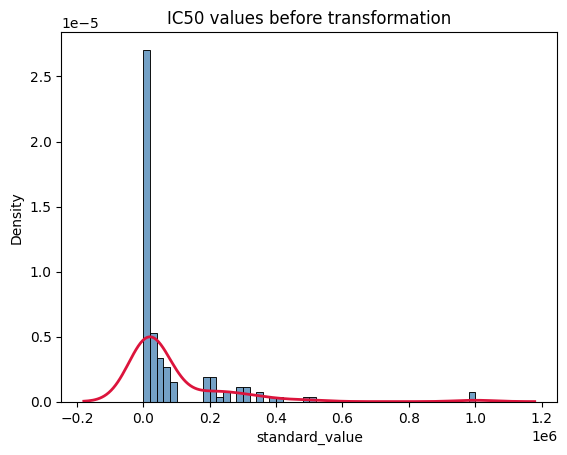

In [14]:
# Create the histogram with bars in metallic blue
ax = sns.histplot(df_combined['standard_value'], 
                  bins=50, 
                  kde=False, 
                  color='steelblue',  # Metallic blue bars
                  edgecolor='black', 
                  stat='density')

# Overlay the KDE line in orange
sns.kdeplot(df_combined['standard_value'], 
            color='crimson', 
            linewidth=2, 
            ax=ax)  # Ensure the KDE is plotted on the same axis

# Display the plot
plt.title('IC50 values before transformation')
plt.savefig('images/plot_IC50_Distribution_no_transformation.pdf')

### *After the log transformation*

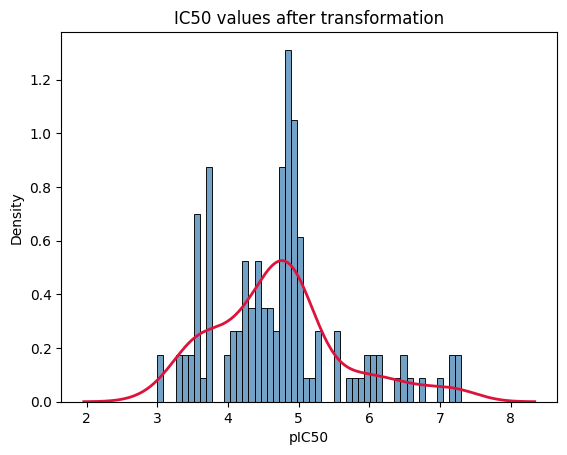

In [15]:
# Create the histogram with bars in metallic blue
ax = sns.histplot(df_final['pIC50'], 
                  bins=50, 
                  kde=False, 
                  color='steelblue',  # Metallic blue bars
                  edgecolor='black', 
                  stat='density')

# Overlay the KDE line in orange
sns.kdeplot(df_final['pIC50'], 
            color='crimson', 
            linewidth=2, 
            ax=ax)  # Ensure the KDE is plotted on the same axis

# Display the plot
plt.title('IC50 values after transformation')
plt.savefig('images/plot_IC50_Distribution_after_transformation.pdf')

---

### ***Removing 'intermediate' bioactivity class***
This will be removed to simplify the comparison between the two bioactivity classes

In [16]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
display(df_2class)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0,4,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0,3,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0,3,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0,3,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0,3,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0,5,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0,3,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0,3,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0,3,4.970616


---

### **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

Chemical space analysis is an effective exploratory data analysis (EDA) tool in drug discovery for several key reasons:

1. **Structural Diversity**  
   Maps and visualizes the structural diversity of compounds using molecular descriptors, helping to assess similarity or uniqueness.

2. **Compound Prioritization**  
   Enables prioritization of compounds for testing by identifying clusters of similar compounds and selecting diverse candidates.

3. **Diversity and Redundancy**  
   Ensures compound libraries cover diverse chemotypes, avoiding redundancy and maximizing discovery potential.

4. **Structure-Activity Relationship (SAR) Exploration**  
   Facilitates the identification of structure-activity relationships, linking chemical modifications to biological activity.

5. **Lead Optimization**  
   Helps find structurally similar compounds that may offer better pharmacological properties during lead optimization.

6. **Predicting Bioactivity**  
   Supports the prediction of compound bioactivity through machine learning models based on chemical space positioning.

7. **Guiding Experimental Design**  
   Provides insights to guide the design of new compound libraries, filling gaps in the chemical space for further exploration.

By analyzing chemical space early, researchers can optimize compound selection, improve lead optimization, and focus on promising drug candidates.

### ***Frequency plot of the 2 bioactivity classes***

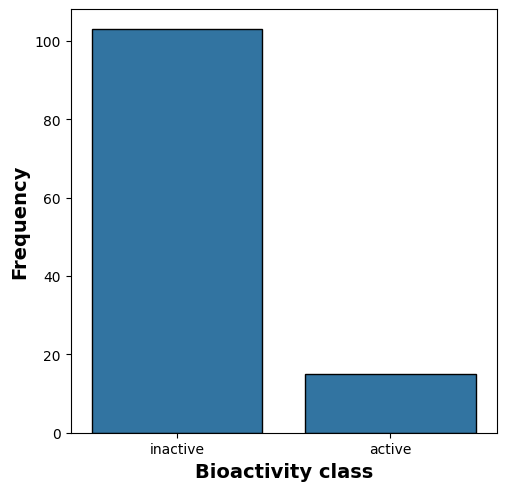

In [17]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('images/plot_bioactivity_class.pdf')

---

### ***Scatter plot of MW versus LogP***

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

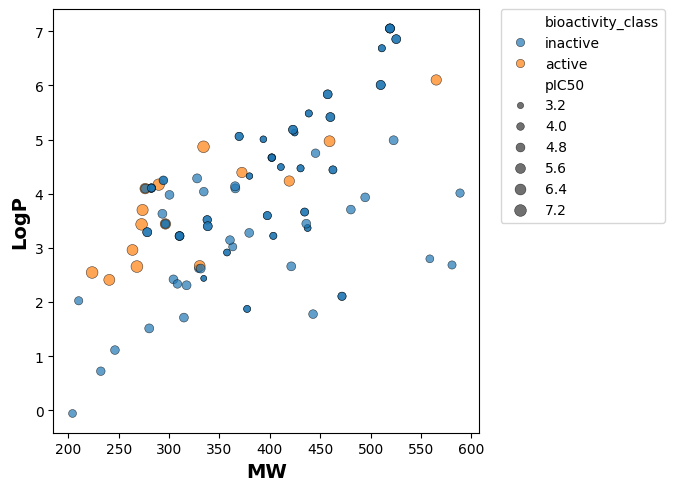

In [18]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('images/plot_MW_vs_LogP.pdf')

---

### ***Box plots and Statistical Analysis***

#### **pIC50 Value**

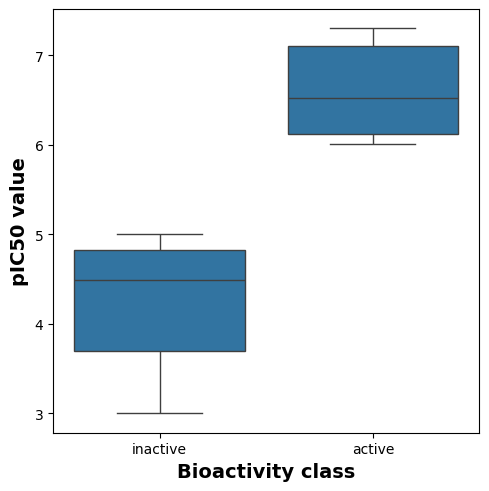

In [19]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('images/plot_ic50.pdf')

***Statistical analysis | Mann-Whitney U Test***

This will be performance to look at the difference between active and inactive classes!

The Mann-Whitney U test (also known as the Wilcoxon rank-sum test) is a non-parametric statistical test used to compare two independent groups. It assesses whether one group tends to have higher or lower values than the other, without assuming that the data follows a normal distribution. It is often used as an alternative to the t-test when the normality assumption is violated.

*Key points*:

+ It works by ranking all the data points from both groups together and then comparing the sum of ranks between the two groups.
+ The test is particularly useful when dealing with small sample sizes or skewed data.
+ It tests the null hypothesis that the distributions of the two groups are identical.

In [20]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'statistics/'+'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [21]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1545.0,4.428384e-10,0.05,Different distribution (reject H0)


***Lipinski Descriptors***

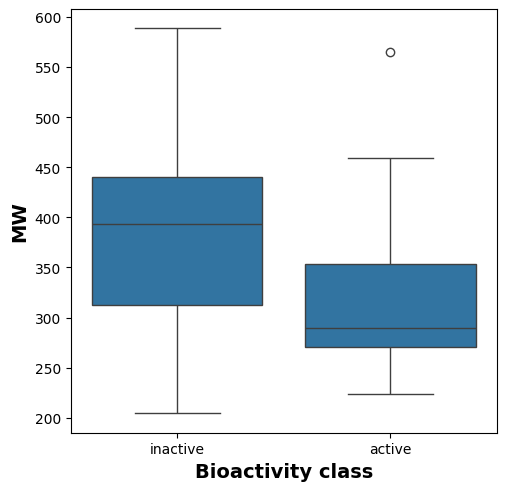

In [22]:
# Molecular Weight

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('images/plot_MW.pdf')

In [23]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,408.5,0.003313,0.05,Different distribution (reject H0)


***Log P***

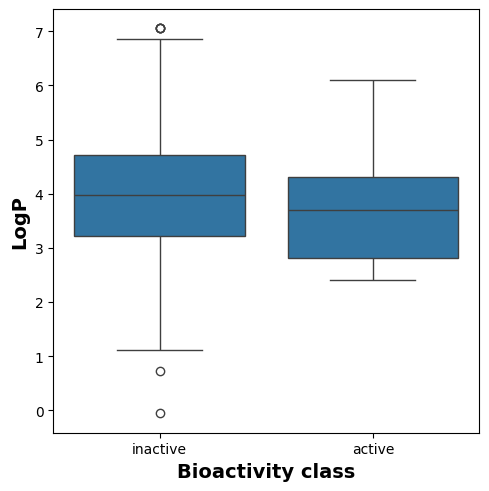

In [24]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('images/plot_LogP.pdf')

In [25]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.630683,0.05,Same distribution (fail to reject H0)


***NumHDonors***

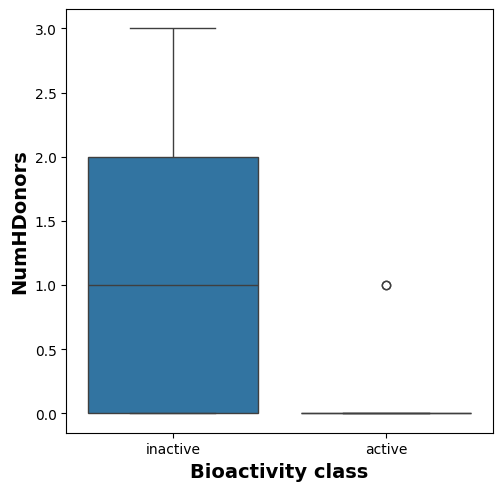

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('images/plot_NumHDonors.pdf')

In [27]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,298.5,0.000053,0.05,Different distribution (reject H0)


***NumHAcceptors***

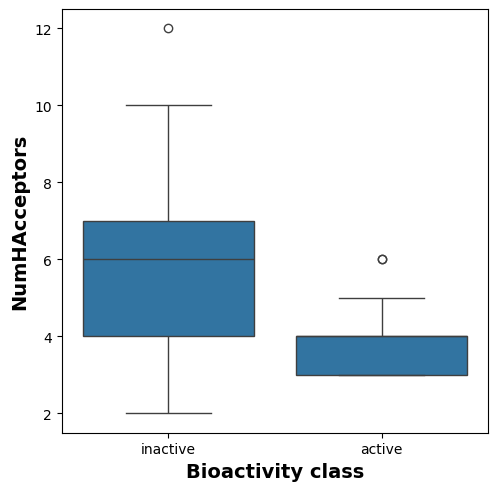

In [28]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('images/plot_NumHAcceptors.pdf')

In [29]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,414.0,0.003402,0.05,Different distribution (reject H0)


### ***Interpretation of Statistical Results***

**Box Plots**

pIC50 values

Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

**Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited no difference between the actives and inactives while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows statistically significant difference between actives and inactives.